In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)

# Build a dataflow graph.
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)

# Construct a `Session` to execute the graph.
sess = tf.compat.v1.Session()

# Execute the graph and store the value that `e` represents in `result`.
result = sess.run(e)
print(result)

2.11.0
[[1. 3.]
 [3. 7.]]


In [3]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [4]:
labels = ['Abnormal(Ulcer)','Normal(Healthy skin)']

In [5]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size, image_size))
        except:
            break
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/DFU_dataset','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 115/115 [00:03<00:00, 36.16it/s]


In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=1010)


In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=1010)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
import keras
import keras.utils
from keras import utils as np_utils
import numpy as np
from keras import layers
from keras.models import Model, load_model
import pydot
from keras.utils.vis_utils import plot_model
from matplotlib.pyplot import imshow

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
resNet50 = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in resNet50.layers:
    layer.trainable = False
x = GlobalAveragePooling2D()(resNet50.output)
x = Dense(1024,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(512,activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=resNet50.inputs, outputs=prediction)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [11]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics= ['accuracy'])

In [12]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DFUNET_XAI.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [13]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Train on 2592 samples, validate on 288 samples
Epoch 1/50
2592/2592 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8900

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to DFUNET_XAI.h5
2592/2592 [==============================] - 36s 14ms/sample - loss: 0.3236 - accuracy: 0.8900 - val_loss: 0.2612 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 2/50
2592/2592 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9410
Epoch 2: val_accuracy did not improve from 0.88889
2592/2592 [==============================] - 11s 4ms/sample - loss: 0.1553 - accuracy: 0.9410 - val_loss: 0.4836 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 3/50
2592/2592 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9595
Epoch 3: val_accuracy improved from 0.88889 to 0.92708, saving model to DFUNET_XAI.h5
2592/2592 [==============================] - 11s 4ms/sample - loss: 0.1124 - accuracy: 0.9595 - val_loss: 0.1873 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 4/50
2592/2592 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9626
Epoch 4: val_accuracy did not improve

In [14]:
# Saving model and weights
from numpy import loadtxt
from keras.models import load_model
model.save("resnet50GradCAM.h5")
model = load_model('/content/resnet50GradCAM.h5')
print("Saved model to disk")

Saved model to disk


In [15]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

Shape of each image : (224, 224, 3)


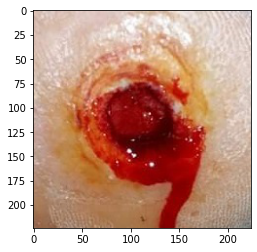

In [46]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Abnormal(Ulcer)/screenshot (256).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)

In [47]:
from keras.activations import softmax, linear
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

In [48]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

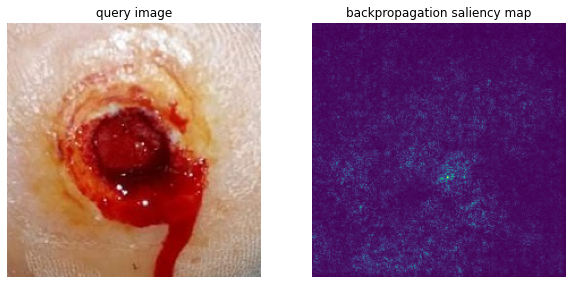

In [49]:
# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

In [50]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [51]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(133)
        plt.title('Guided backpropagation')
        plt.axis('off')
        plt.imshow(np.squeeze(gb, 0))

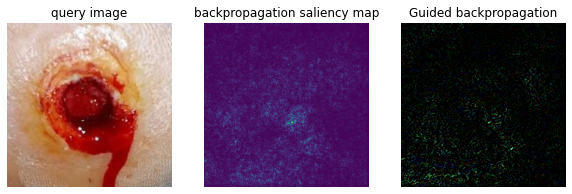

In [52]:
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv5_block3_3_conv')

In [53]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

In [40]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv5_block3_3_conv' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        

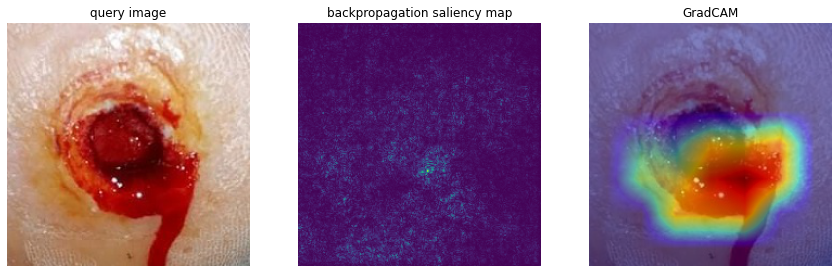

In [55]:
# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv5_block3_3_conv')

In [56]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

In [57]:
def GradCamPlusPlus(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    height = np.expand_dims(query_image,0).shape[-2]
    weidth = np.expand_dims(query_image,0).shape[-3]
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0  
    cam = cv2.resize(cam, (height, weidth), cv2.INTER_LINEAR)
    
    return cam

In [58]:
def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  


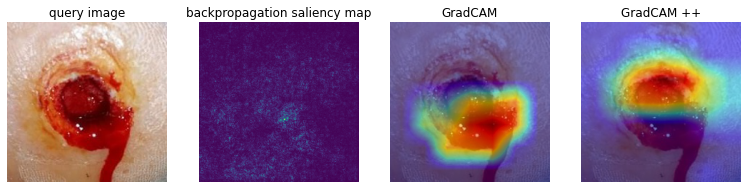

In [59]:
gradcamplus_saliency_map(model, query_image, -1, 'conv5_block3_3_conv')

Shape of each image : (224, 224, 3)


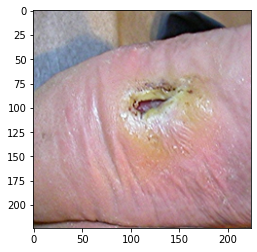

resized_img Dimensions :  (224, 224, 3)


In [ ]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Abnormal(Ulcer)/image (116).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [ ]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

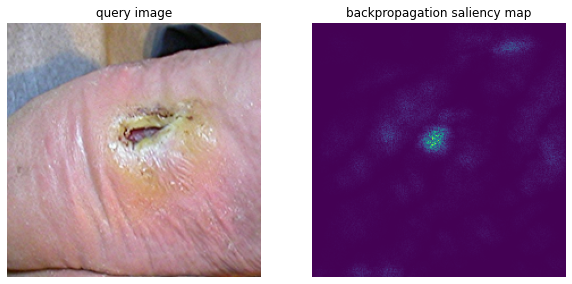

In [ ]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

In [ ]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

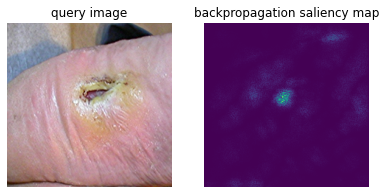

In [ ]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv5_block3_3_conv')

In [ ]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

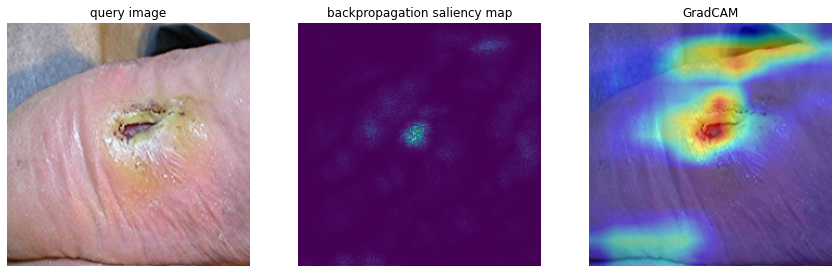

In [ ]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv5_block3_3_conv' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv5_block3_3_conv')

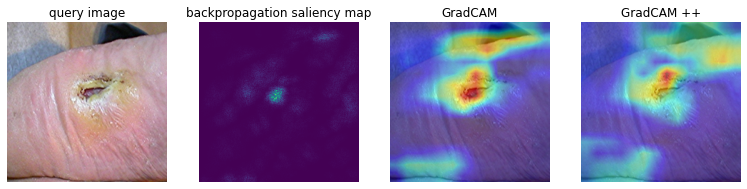

In [ ]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  

gradcamplus_saliency_map(model, query_image, -1, 'conv5_block3_3_conv')

Shape of each image : (224, 224, 3)


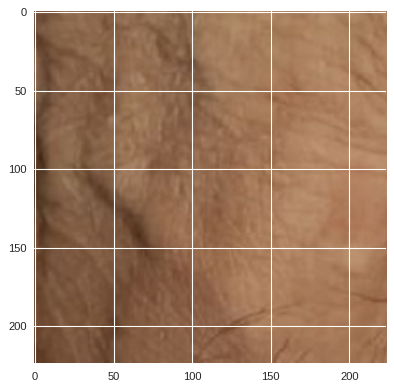

resized_img Dimensions :  (224, 224, 3)


In [100]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Normal(Healthy skin)/image (115).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [101]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

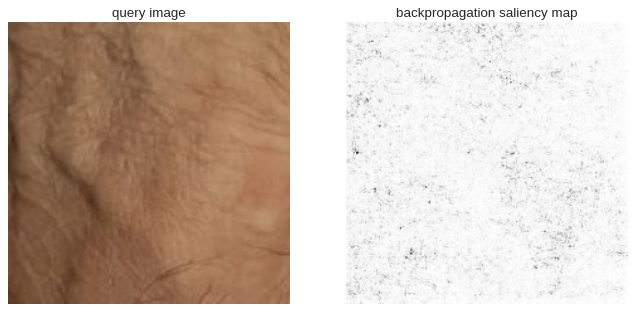

In [102]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

In [103]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

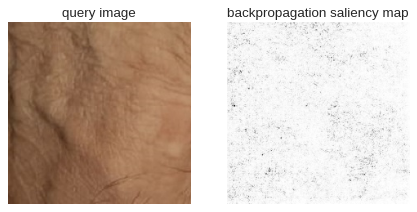

In [104]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv5_block3_3_conv')

In [105]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

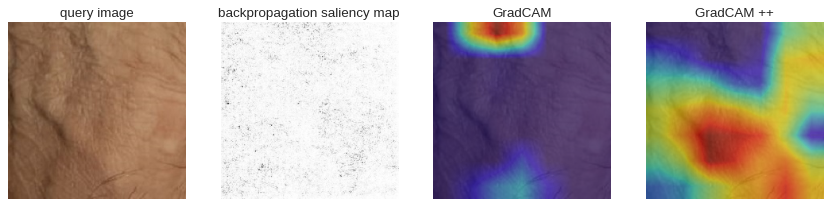

In [106]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  

gradcamplus_saliency_map(model, query_image, -1, 'conv5_block3_3_conv')

Shape of each image : (224, 224, 3)


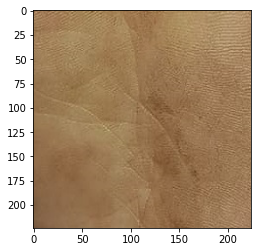

resized_img Dimensions :  (224, 224, 3)


In [60]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Normal(Healthy skin)/image (116).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

In [61]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

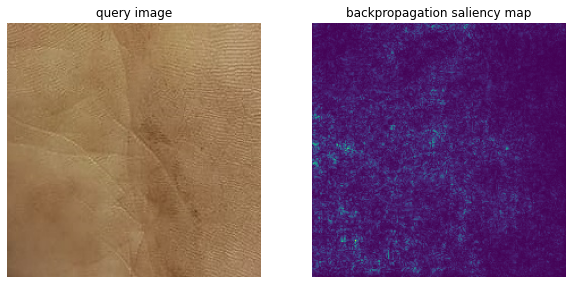

In [62]:
# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

In [63]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

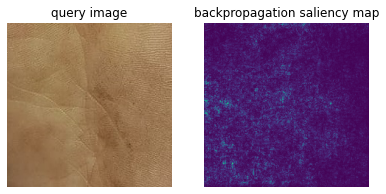

In [64]:
def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv5_block3_3_conv')

In [65]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

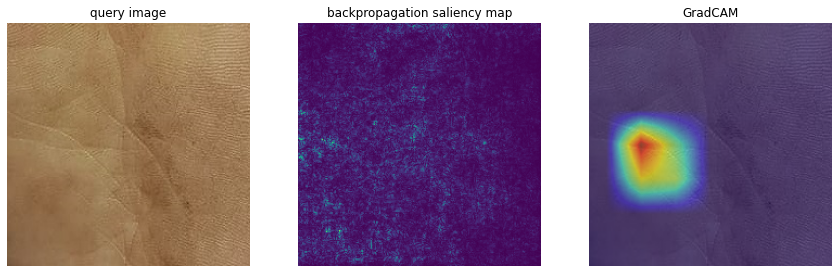

In [67]:
def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv5_block3_3_conv' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv5_block3_3_conv')

In [68]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

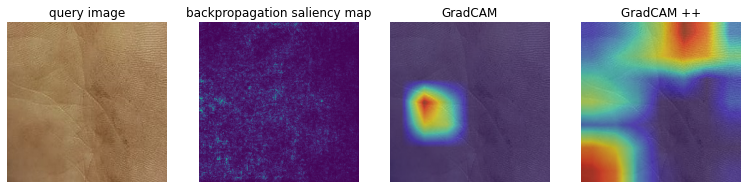

In [69]:
def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  

gradcamplus_saliency_map(model, query_image, -1, 'conv5_block3_3_conv')

Shape of each image : (224, 224, 3)


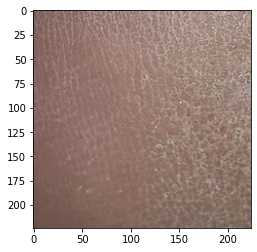

resized_img Dimensions :  (224, 224, 3)


In [70]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Normal(Healthy skin)/image (119).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

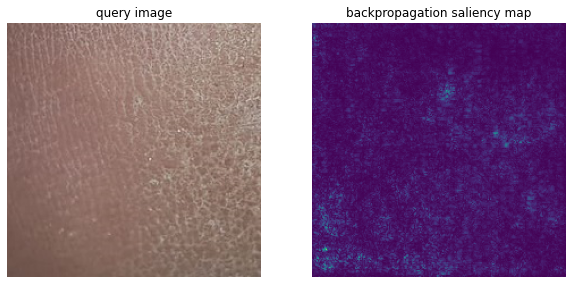

In [71]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

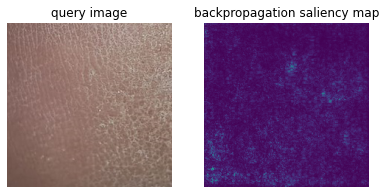

In [72]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv5_block3_3_conv')

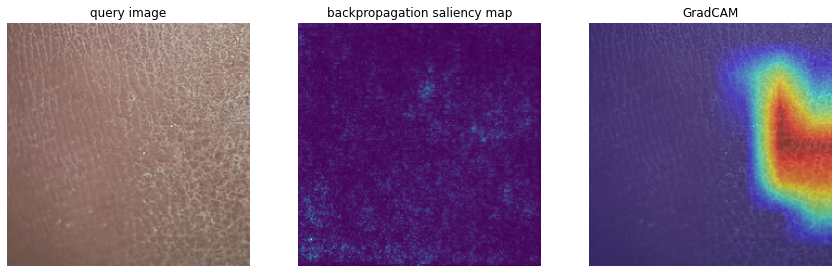

In [73]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv5_block3_3_conv' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv5_block3_3_conv')

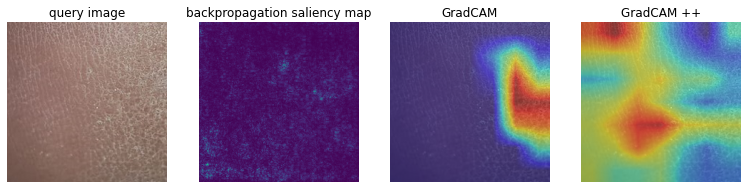

In [74]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  

gradcamplus_saliency_map(model, query_image, -1, 'conv5_block3_3_conv')

Shape of each image : (224, 224, 3)


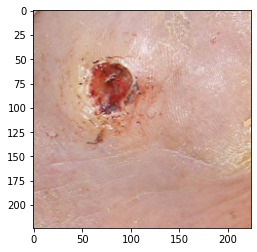

resized_img Dimensions :  (224, 224, 3)


In [76]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Abnormal(Ulcer)/Screenshot_5.jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

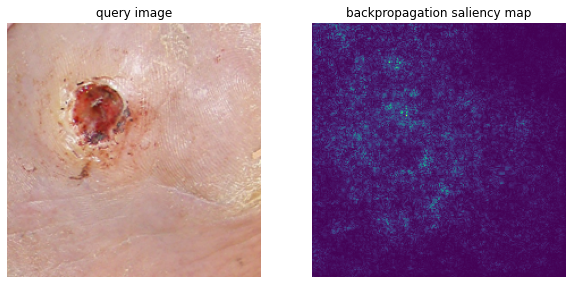

In [77]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

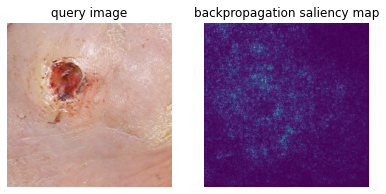

In [78]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv5_block3_3_conv')

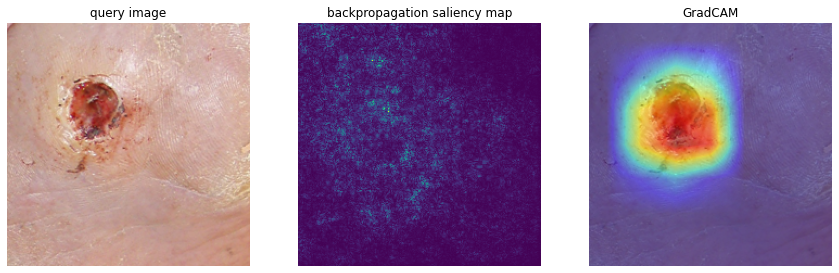

In [79]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv5_block3_3_conv' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv5_block3_3_conv')

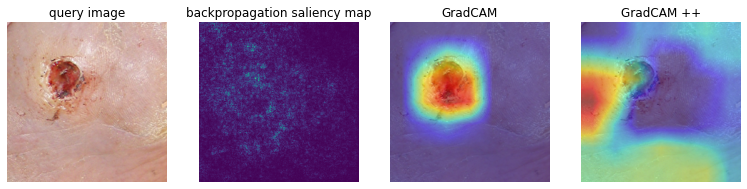

In [80]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  

gradcamplus_saliency_map(model, query_image, -1, 'conv5_block3_3_conv')

Shape of each image : (224, 224, 3)


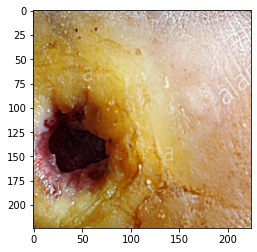

resized_img Dimensions :  (224, 224, 3)


In [81]:
# Query image to explain
import cv2
image = load_img("/content/drive/MyDrive/DFU_dataset/check_model/Abnormal(Ulcer)/screenshot (244).jpg")
image = np.array(image)
print(f"Shape of each image : {image.shape}")
plt.imshow(image)
plt.show()

query_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
print('resized_img Dimensions : ',query_image.shape)
from keras.activations import softmax, linear
from keras.activations import softmax, linear

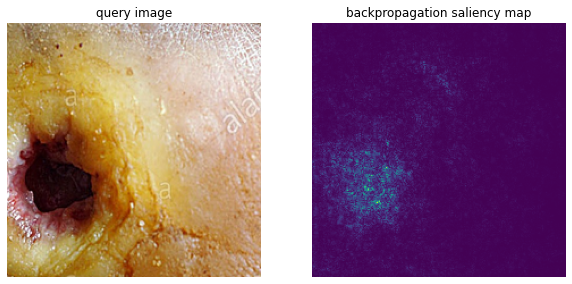

In [82]:
# Saliency map using Backpropagation w.r.t. input
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
def unnormed_output_model(model):
    '''
    unnormed_output_model return a model exactly same as vgg16, except that the output
    layer use a linear activation rather than softmax
    '''
    
    #check if last layer has softmax as activation
    assert model.layers[-1].activation == softmax

    #get the weights from last layer
    weights = model.layers[-1].get_weights()
        
    #create a new layer as last layer, set it weights use 'weights'
    config = model.layers[-1].get_config()
    config['activation'] = None
    config['name'] = 'pred'
    lastlayer_without_softmax = Dense(**config)(model.layers[-2].output)
    
    #build a new model, and set lastlayers weight
    model_without_softmax = Model(inputs=model.input, outputs=[lastlayer_without_softmax])
    model_without_softmax.layers[-1].set_weights(weights)
    
    #check if last layer is linear
    assert model_without_softmax.layers[-1].activation == linear
    
    return model_without_softmax

def backprop_saliency_map(model, img):

    #calculate grads to input image
    variable = model.input
    loss = model.layers[-1].output
    grads = K.gradients (loss, variable)
    func = K.function([variable], [grads, loss])
      
    #use the maximum absolute value among channels per pixel
    w, loss_value = func(img)
    saliency_map = np.max(np.absolute(w[0][0]), axis=2)
    return saliency_map

# Backpropagation saliency map
def backpropagation(model, query_img, visualise=True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, query_img)

    if visualise:
        plt.figure(figsize=(10, 20))
        plt.subplot(121)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(np.squeeze(query_img,0))
        
        plt.subplot(122)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

# Backpropagation saliency map
backpropagation(model, np.expand_dims(query_image,0))

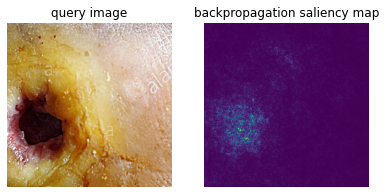

In [83]:
# Guided Backpropagation

def build_guided_model():

    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

def guided_backprop_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)

    if visualise:
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(132)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)
# guided Backpropagation
guided_backprop_saliency_map(model, (query_image), layer_name='conv5_block3_3_conv')

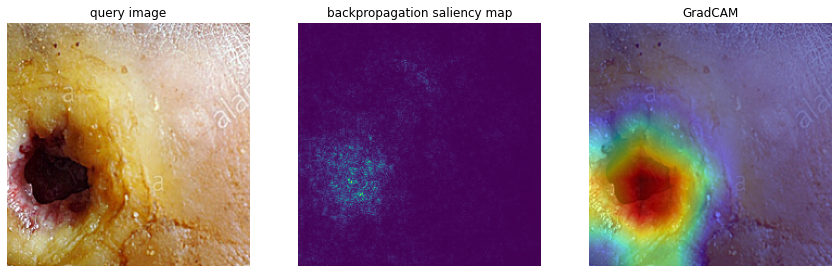

In [84]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  
    cam = cv2.resize(cam, (224,224))

    return cam

def gradcam_saliency_map(model, query_input, layer_name , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0), layer_name='conv5_block3_3_conv' )
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(141)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(142)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(143)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

# Visualising GradCAM and GradCAM++
gradcam_saliency_map(model, query_image, 'conv5_block3_3_conv')

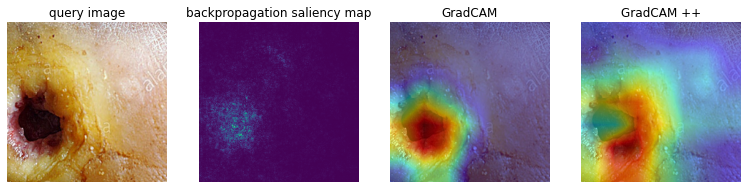

In [85]:
# old
def grad_cam_plus(input_model, img, cls, layer_name, H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    # print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = cam / np.max(cam) # scale 0 to 1.0    

    return cam

def gradcamplus_saliency_map(model, query_input, cls, layer_name  , visualise = True):

    # Gradient Saliency map
    model_without_softmax = unnormed_output_model(model)
    backpropagation_saliency_map = backprop_saliency_map(model_without_softmax, np.expand_dims(query_input,0))
    gb = guided_backprop(model, np.expand_dims(query_input, 0), layer_name)
    gradcam = GradCam(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcam = gb * gradcam[..., np.newaxis]
    gradcampp = GradCamPlusPlus(model, np.expand_dims(query_input,0),  layer_name=layer_name )
    guided_gradcampp = gb * gradcampp[..., np.newaxis]

    if visualise:
        plt.figure(figsize=(20, 20))
        plt.subplot(161)
        plt.title('query image')
        plt.axis('off')
        plt.imshow(query_input)
  
        plt.subplot(162)
        plt.title('backpropagation saliency map')
        plt.axis('off')
        plt.imshow(backpropagation_saliency_map)

        plt.subplot(163)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(164)
        plt.title('GradCAM ++')
        plt.axis('off')
        plt.imshow(query_input)
        plt.imshow(gradcampp, cmap='jet', alpha=0.5)  

gradcamplus_saliency_map(model, query_image, -1, 'conv5_block3_3_conv')

<ipython-input-88-304f3438c41a>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


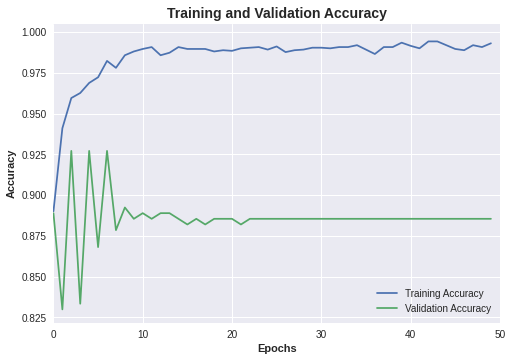

In [88]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy',fontweight='bold')
plt.xlim([0,50])
plt.ylim([min(plt.ylim()),1.005])
plt.title('Training and Validation Accuracy',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('ResNet50TV15',dpi=400)
plt.show()

In [89]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-89-036bcfb1f050>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


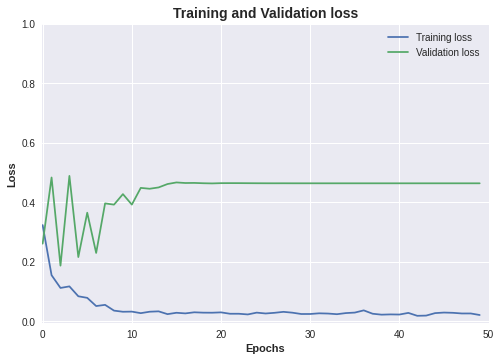

In [90]:
acc = history.history['loss']
val_acc = history.history['val_loss']

plt.plot(acc, label='Training loss')
plt.plot(val_acc, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Loss',fontweight='bold')
plt.xlim([-0.05,50])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation loss',fontweight='bold', fontsize=14)
plt.xlabel('Epochs',fontweight='bold')
# plt.legend(loc='best')
plt.savefig('ResNet50TV31',dpi=400)
plt.show()

In [86]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.87       196
           1       0.74      1.00      0.85       124

    accuracy                           0.86       320
   macro avg       0.87      0.89      0.86       320
weighted avg       0.90      0.86      0.86       320



In [87]:
cm = confusion_matrix(y_test_new, pred)

Confusion matrix, without normalization


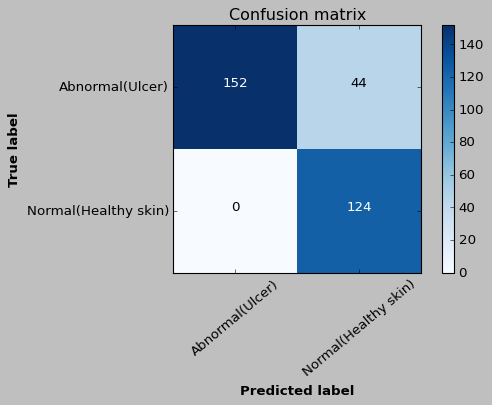

In [91]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues, fontweight='bold'):
    
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

plot_confusion_matrix(cm,labels)
plt.savefig('ResNet50CM11',dpi=400)

In [92]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]

In [98]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score

print('Accuracy: %.5f' % accuracy_score(y_test_new, pred), 'Precision: %.5f' % precision_score(y_test_new, pred),' Recall: %.5f' % recall_score(y_test_new, pred), 
      'F1 Score: %.5f' % f1_score(y_test_new, pred), 'AUC Score: %.5f' % roc_auc_score(y_test_new, pred))

Accuracy: 0.86250 Precision: 0.73810  Recall: 1.00000 F1 Score: 0.84932 AUC Score: 0.88776


In [94]:
specificity=TN/float(TN+FP)
print(specificity)
print(roc_auc_score(y_test_new, pred))
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_new, pred)

0.7755102040816326
0.8877551020408163


0.1375

In [95]:
acc = accuracy_score(y_test_new, pred)*100
auc=roc_auc_score(y_test_new, pred)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
specificity = tn/(tn+fp)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall or Sensitivity: {0:0.2f}%'.format(recall))
print('Specificity: {0:0.2f}%'.format(specificity))
print('F1-score: {0:0.2f}%'.format(2*precision*recall/(precision+recall)))
print('AUC-score: {0:0.2f}%'.format(auc))
print('Train acc: {0:0.2f}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

Accuracy: 86.25%
Precision: 73.81%
Recall or Sensitivity: 100.00%
Specificity: 77.55%
F1-score: 84.93%
AUC-score: 88.78%
Train acc: 99.31%


<ipython-input-99-44e7c04025ca>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


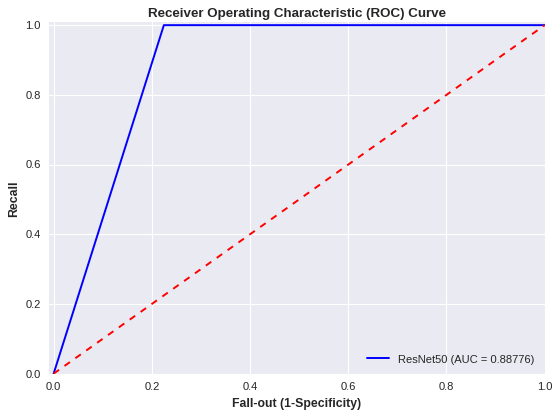

In [99]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test_new, pred)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(false_positive_rate, recall, 'b', label = 'ResNet50 (AUC = %0.5f)' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('ResNet50AUC12',dpi=400)
plt.show()